# Completeness Score: Evaluando la Cobertura en Clustering


In [14]:
import os, warnings
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import completeness_score, homogeneity_score, v_measure_score, adjusted_rand_score
from sklearn.metrics.cluster import contingency_matrix   # <--- CORRECTO AQUÍ
from collections import Counter

# Configuración general
os.environ["OMP_NUM_THREADS"] = "2"
warnings.filterwarnings("ignore", message="KMeans is known to have a memory leak")

np.random.seed(42)
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("=== MÉTRICA: COMPLETENESS SCORE ===\n")


=== MÉTRICA: COMPLETENESS SCORE ===



In [16]:
# Generar datos con estructura conocida
X, y_true = make_blobs(
    n_samples=300,
    centers=4,
    n_features=2,
    random_state=42,
    cluster_std=1.5
)

print(f"Datos generados: {X.shape[0]} puntos, {len(np.unique(y_true))} clases verdaderas.")


Datos generados: 300 puntos, 4 clases verdaderas.


In [18]:
k_values = [2, 3, 4, 5, 6]
results = []

print("\n=== EVALUACIÓN DE DIFERENTES VALORES DE K ===")

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    y_pred = kmeans.fit_predict(X)
    
    completeness = completeness_score(y_true, y_pred)
    homogeneity = homogeneity_score(y_true, y_pred)
    v_measure = v_measure_score(y_true, y_pred)
    ari = adjusted_rand_score(y_true, y_pred)
    
    results.append({
        'k': k,
        'completeness': completeness,
        'homogeneity': homogeneity,
        'v_measure': v_measure,
        'ari': ari
    })
    
    print(f"\nK={k} clusters:")
    print(f"  Completeness Score: {completeness:.3f}")
    print(f"  Homogeneity Score:  {homogeneity:.3f}")
    print(f"  V-Measure:          {v_measure:.3f}")



=== EVALUACIÓN DE DIFERENTES VALORES DE K ===

K=2 clusters:
  Completeness Score: 1.000
  Homogeneity Score:  0.406
  V-Measure:          0.577

K=3 clusters:
  Completeness Score: 1.000
  Homogeneity Score:  0.750
  V-Measure:          0.857

K=4 clusters:
  Completeness Score: 0.987
  Homogeneity Score:  0.987
  V-Measure:          0.987

K=5 clusters:
  Completeness Score: 0.870
  Homogeneity Score:  0.966
  V-Measure:          0.916

K=6 clusters:
  Completeness Score: 0.777
  Homogeneity Score:  0.965
  V-Measure:          0.861


In [20]:
kmeans_optimal = KMeans(n_clusters=4, random_state=42, n_init=10)
y_pred_optimal = kmeans_optimal.fit_predict(X)

score_optimal = completeness_score(y_true, y_pred_optimal)

print("\n=== ANÁLISIS DETALLADO (K=4) ===")
print(f"Completeness Score: {score_optimal:.3f}")



=== ANÁLISIS DETALLADO (K=4) ===
Completeness Score: 0.987


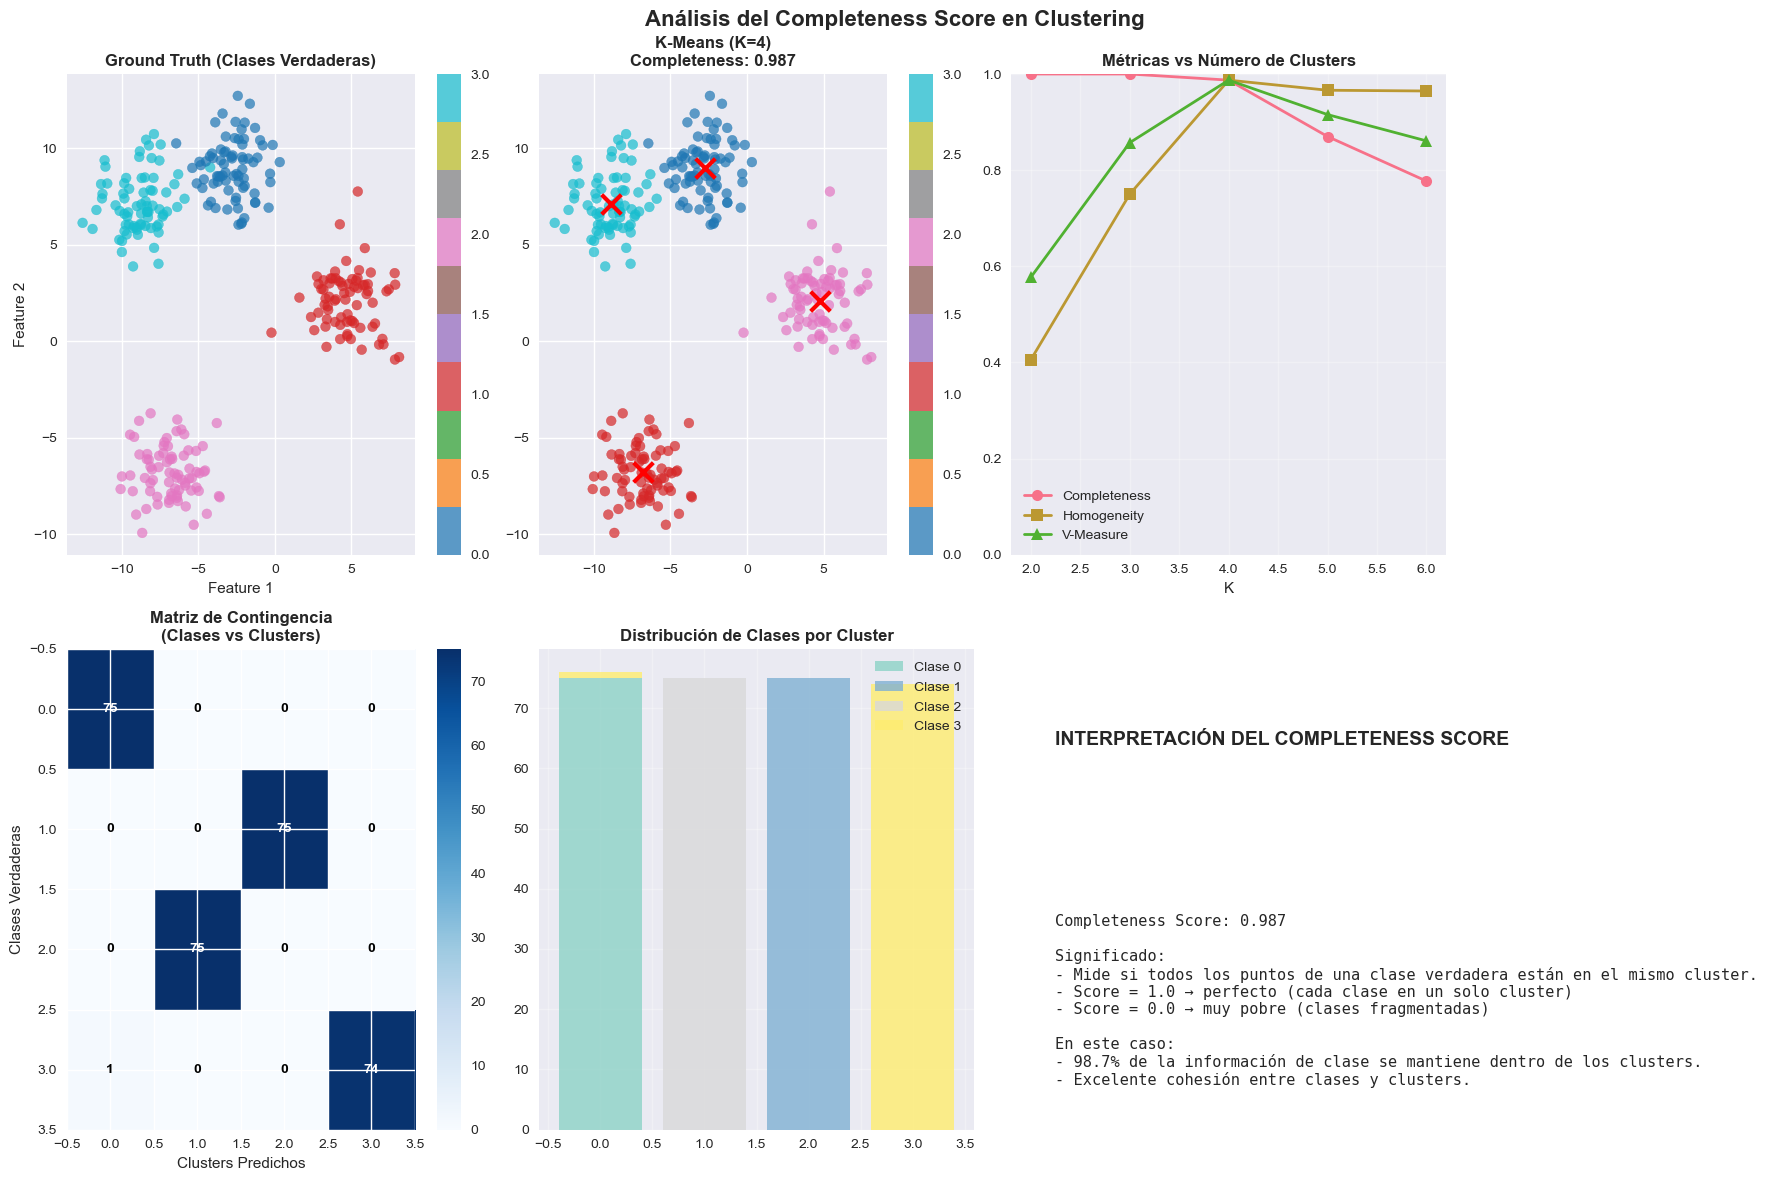

In [22]:
def plot_clustering_results():
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Análisis del Completeness Score en Clustering', fontsize=16, fontweight='bold')
    
    # --- (1) Ground Truth ---
    scatter1 = axes[0,0].scatter(X[:, 0], X[:, 1], c=y_true, cmap='tab10', alpha=0.7, s=50)
    axes[0,0].set_title('Ground Truth (Clases Verdaderas)', fontweight='bold')
    axes[0,0].set_xlabel('Feature 1')
    axes[0,0].set_ylabel('Feature 2')
    plt.colorbar(scatter1, ax=axes[0,0])
    
    # --- (2) Clustering K=4 ---
    scatter2 = axes[0,1].scatter(X[:, 0], X[:, 1], c=y_pred_optimal, cmap='tab10', alpha=0.7, s=50)
    centers = kmeans_optimal.cluster_centers_
    axes[0,1].scatter(centers[:, 0], centers[:, 1], c='red', marker='x', s=200, linewidths=3)
    axes[0,1].set_title(f'K-Means (K=4)\nCompleteness: {score_optimal:.3f}', fontweight='bold')
    plt.colorbar(scatter2, ax=axes[0,1])
    
    # --- (3) Métricas vs número de clusters ---
    df_results = pd.DataFrame(results)
    axes[0,2].plot(df_results['k'], df_results['completeness'], 'o-', label='Completeness', linewidth=2, markersize=8)
    axes[0,2].plot(df_results['k'], df_results['homogeneity'], 's-', label='Homogeneity', linewidth=2, markersize=8)
    axes[0,2].plot(df_results['k'], df_results['v_measure'], '^-', label='V-Measure', linewidth=2, markersize=8)
    axes[0,2].set_title('Métricas vs Número de Clusters', fontweight='bold')
    axes[0,2].legend()
    axes[0,2].set_xlabel('K')
    axes[0,2].set_ylim(0, 1)
    axes[0,2].grid(True, alpha=0.3)
    
    # --- (4) Matriz de contingencia ---
    contingency = contingency_matrix(y_true, y_pred_optimal)
    im = axes[1,0].imshow(contingency, cmap='Blues', aspect='auto')
    axes[1,0].set_title('Matriz de Contingencia\n(Clases vs Clusters)', fontweight='bold')
    axes[1,0].set_xlabel('Clusters Predichos')
    axes[1,0].set_ylabel('Clases Verdaderas')
    
    for i in range(contingency.shape[0]):
        for j in range(contingency.shape[1]):
            axes[1,0].text(j, i, f'{contingency[i,j]}',
                          ha='center', va='center',
                          color='white' if contingency[i,j] > contingency.max()/2 else 'black',
                          fontweight='bold')
    plt.colorbar(im, ax=axes[1,0])
    
    # --- (5) Distribución de clases por cluster ---
    cluster_class_dist = []
    for cluster in range(4):
        mask = y_pred_optimal == cluster
        class_counts = Counter(y_true[mask])
        for class_label, count in class_counts.items():
            cluster_class_dist.append({'Cluster': cluster, 'Clase': class_label, 'Puntos': count})
    
    df_dist = pd.DataFrame(cluster_class_dist)
    pivot_dist = df_dist.pivot(index='Cluster', columns='Clase', values='Puntos').fillna(0)
    
    bottom = np.zeros(len(pivot_dist))
    colors = plt.cm.Set3(np.linspace(0, 1, len(pivot_dist.columns)))
    
    for i, clase in enumerate(pivot_dist.columns):
        axes[1,1].bar(pivot_dist.index, pivot_dist[clase], bottom=bottom,
                     label=f'Clase {int(clase)}', color=colors[i], alpha=0.8)
        bottom += pivot_dist[clase]
    
    axes[1,1].set_title('Distribución de Clases por Cluster', fontweight='bold')
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)
    
    # --- (6) Interpretación textual ---
    axes[1,2].text(0.1, 0.8, 'INTERPRETACIÓN DEL COMPLETENESS SCORE', 
                   fontsize=14, fontweight='bold', transform=axes[1,2].transAxes)
    
    interpretation_text = f"""
Completeness Score: {score_optimal:.3f}

Significado:
- Mide si todos los puntos de una clase verdadera están en el mismo cluster.
- Score = 1.0 → perfecto (cada clase en un solo cluster)
- Score = 0.0 → muy pobre (clases fragmentadas)

En este caso:
- {score_optimal:.1%} de la información de clase se mantiene dentro de los clusters.
- {'Excelente' if score_optimal > 0.8 else 'Buena' if score_optimal > 0.6 else 'Mejorable'} cohesión entre clases y clusters.
"""
    axes[1,2].text(0.1, 0.05, interpretation_text, transform=axes[1,2].transAxes,
                   fontsize=11, verticalalignment='bottom', fontfamily='monospace')
    axes[1,2].axis('off')
    
    plt.tight_layout()
    plt.show()

plot_clustering_results()


In [24]:
print("\n=== COMPARACIÓN: CLUSTERING ÓPTIMO vs SUBÓPTIMO ===")

kmeans_suboptimal = KMeans(n_clusters=2, random_state=42)
y_pred_suboptimal = kmeans_suboptimal.fit_predict(X)

score_sub = completeness_score(y_true, y_pred_suboptimal)

print(f"Clustering óptimo (K=4): Completeness = {score_optimal:.3f}")
print(f"Clustering subóptimo (K=2): Completeness = {score_sub:.3f}")
print(f"Diferencia: {score_optimal - score_sub:.3f}")

print("\nUn valor más alto de completeness indica que el modelo preserva mejor las clases reales dentro de los clusters.")



=== COMPARACIÓN: CLUSTERING ÓPTIMO vs SUBÓPTIMO ===
Clustering óptimo (K=4): Completeness = 0.987
Clustering subóptimo (K=2): Completeness = 1.000
Diferencia: -0.013

Un valor más alto de completeness indica que el modelo preserva mejor las clases reales dentro de los clusters.
